packages import module

In [12]:
#import packages
!pip install scikit-surprise

In [13]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from surprise import Dataset, Reader
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

datasets import module

In [14]:
#import dataset
events_df = pd.read_csv('processed events.csv').drop(columns='Unnamed: 0')

DATA: RATING 1-3-6

In [15]:
#1-3-6 structure
events_df.astype("int32")
events_df=events_df.fillna(0).astype(int)
#events_df

In [16]:
reader = Reader(rating_scale=(1, 6))
data = Dataset.load_from_df(events_df[['visitorid', 'itemid', 'event']], reader)

algorithm selection module


In [28]:
"""
the model selection module, including KNNs (4 models,3 similarities), model-based (SVD, NMF).
change the parameter model to get different data.

model=SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
similarities=cosine, msd, pearson

like model = SVD(), model = KNNBaseline(sim_option="msd")
"""
model = SVD()
modelResult = cross_validate(model, data, cv=3)
pd.DataFrame(modelResult).mean()



test_rmse     0.975756
test_mae      0.476093
fit_time     14.816194
test_time     0.842333
dtype: float64

machine learning module


training

In [12]:
#prediction KNN
trainset, testset = train_test_split(data, test_size=0.2)

model = KNNWithZScore(k=45,min_k=5,sim_option="Pearson")
model.fit(trainset)
predictions = model.test(testset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [10]:
#prediction SVD
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=60, n_epochs=40, lr_all=0.004, reg_all=0.24)
model.fit(trainset)
predictions = model.test(testset)


In [ ]:
#test cell
predictions

Evaluating module. There is only one *predictions* variable, run the KNN or the SVD cell to proceed.

In [ ]:
def classify(rating, ignore):
    event=0.5
    if ignore < rating <= 2.0:
        event=1
    elif 2.0 < rating <= 3.5:
        event=3
    elif rating>3.5:
        event=6
    return event


In [ ]:
#calculate percision and recall

def precision_recall_at_k(predictions, k=10, threshold=1, ignore=1):

    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((classify(est, ignore), true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
#print precision and recall
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=1, ignore=1.2)

print("precision = ",end="")
print(sum(prec for prec in precisions.values()) / len(precisions))

print("recall = ",end="")
print(sum(rec for rec in recalls.values()) / len(recalls))



In [23]:
#prediction
df_pred = pd.DataFrame(predictions, columns=['visitorid', 'itemid', 'actual_rating', 'pred_rating', 'details'])

df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred['round_err']=abs(df_pred['pred_rating_round'] - df_pred['actual_rating'])
df_pred['pred_classified']=df_pred['pred_rating_round'].replace(2.0,1.0).replace(4.0,3.0).replace(5.0,6.0)
df_pred['err_classified']=abs(df_pred['pred_classified'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,visitorid,itemid,actual_rating,pred_rating,impossible,pred_rating_round,abs_err,round_err,pred_classified,err_classified
50199,665732,136546,1.0,1.110334,False,1.0,0.110334,0.0,1.0,0.0
46641,1150086,398115,6.0,1.706111,False,2.0,4.293889,4.0,1.0,5.0
19247,244756,25002,1.0,1.000000,False,1.0,0.000000,0.0,1.0,0.0
10305,683140,444697,1.0,1.602900,False,2.0,0.602900,1.0,1.0,0.0
19631,233961,28312,1.0,1.000000,False,1.0,0.000000,0.0,1.0,0.0


In [23]:
#test cell
df_pred.groupby("pred_rating_round").count()


,visitorid,itemid,actual_rating,pred_rating,impossible,abs_err,round_err,pred_classified,err_classified
pred_rating_round,,,,,,,,,
1.0,60220,60220,60220,60220,60220,60220,60220,60220,60220
2.0,11014,11014,11014,11014,11014,11014,11014,11014,11014
3.0,2548,2548,2548,2548,2548,2548,2548,2548,2548
4.0,868,868,868,868,868,868,868,868,868
5.0,257,257,257,257,257,257,257,257,257
6.0,482,482,482,482,482,482,482,482,482


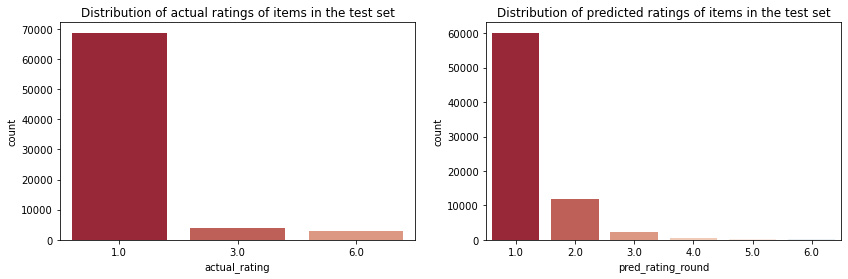

In [13]:
#actual&prediction plot

palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of items in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of items in the test set')

plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


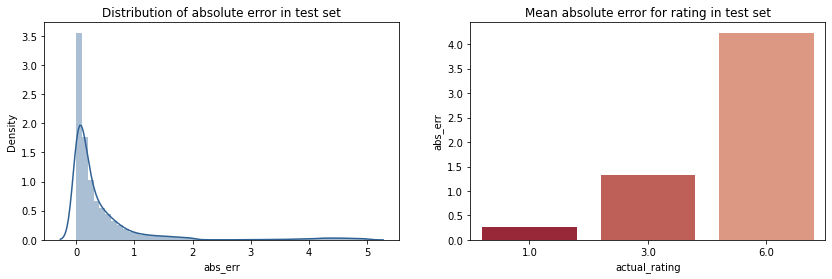

In [24]:
#error distribution plot
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')
sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()